In [300]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import markdown
from IPython.core.display import display, HTML
import seaborn as sns
import scipy.stats as stats
import pypandoc

%matplotlib inline

In [301]:
data = pd.read_csv("Dados-medicos.txt", " ")
data.drop("Unnamed: 1", axis=1, inplace=True)
data.drop("Unnamed: 2", axis=1, inplace=True)
data.columns = ["idade", "peso", "carga", "vo2"]
pd.set_option("display.max_colwidth", 1000)

### Parte 1: análise dos dados

Idade mínima: 18
Idade máxima: 91
Foram consideradas faixas etária de 20 a 90 anos, os valores extremos 
encaixados nas faixas etárias mais próximas.


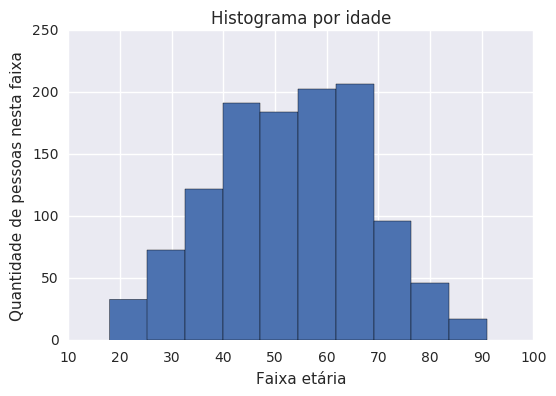

In [302]:
ax = data['idade'].hist()
ax.set_title("Histograma por idade")
ax.set_xlabel("Faixa etária")
ax.set_ylabel("Quantidade de pessoas nesta faixa")

print("Idade mínima: %d" % data['idade'].min())
print("Idade máxima: %d" % data['idade'].max())
print("Foram consideradas faixas etária de 20 a 90 anos, os valores extremos \n"
      "encaixados nas faixas etárias mais próximas.")

### Parte 2: Separação em treino e teste

In [303]:
# Separar o dataset nas respectivas faixas
faixas = []
idade_anterior = 0
for idade in range(30, 100, 20):
    if idade == 90:
        idade = 100
    faixas.append(data[(data['idade'] >= idade_anterior) & (data['idade'] < idade)])
    idade_anterior = idade

idade_total = 0
train = []
test = []
# Separar metade dos dados
for i, item in enumerate(faixas):
    #item.drop('peso', axis=1, inplace=True)
    idade = (i+2)*10
    idade_total += item.shape[0]
    train.append(item[0:item.shape[0]//2])
    test.append(item[item.shape[0]//2:])
    idade_final = idade +10
    if idade == 20:
        idade = 18
    if idade == 50:
        idade_final = 91
    print("Faixa %d-%d possui %d pessoas para treino e %d para teste." % (idade,idade_final, 
                                                                          train[i].shape[0], test[i].shape[0]))
print("Total de participantes: %d" % idade_total)

Faixa 18-30 possui 34 pessoas para treino e 34 para teste.
Faixa 30-40 possui 202 pessoas para treino e 203 para teste.
Faixa 40-50 possui 270 pessoas para treino e 270 para teste.
Faixa 50-91 possui 79 pessoas para treino e 80 para teste.
Total de participantes: 1172


### Parte 3: Como eu observo todos os dados, é possível calcular média e variância para cada gaussiana.

In [304]:
def media(dados):
    mu = dados.sum()/dados.shape[0]
    return mu

def variancia(dados):
    var = ((dados - media(dados))**2).sum()
    var = var/dados.shape[0]
    return var

def covariancia(dados, var):
    for i in range(dados.shape[1]):
        for j in range(i+1, dados.shape[1]):
            for row in dados.iterrows():
                cov = (row[1][i]-media(dados[dados.columns[i]]))*(row[1][j]-media(dados[dados.columns[j]]))
                var[i,j] += cov
                var[j,i] += cov
            var[i,j] = var[i,j]/dados.shape[0]
            var[j,i] = var[j,i]/dados.shape[0]
        
    return var

def covariancia_matrix(dados):
    var_diag = variancia(dados)
    var = np.diag(var_diag)
    var = covariancia(dados, var)
    return var

In [305]:
def normal_multivariate(mu, sigma, dados):
    return (np.linalg.det(2*np.pi*sigma)**(-1/2))*np.exp(-1/2 * np.dot(np.dot((dados-mu), np.linalg.inv(sigma)), (dados-mu).T))

%matplotlib inline
def plot_normal3d(x_label, y_label, dados, x_min, x_max, y_min, y_max):
    mu = media(dados)
    sigma = covariancia_matrix(dados)

    #x_axis = np.linspace(dados[x_label].min(), dados[x_label].max(), 100)
    x_axis = np.linspace(x_min, x_max, 100)
    #y_axis = np.linspace(dados[y_label].min(), dados[y_label].max(), 100)
    y_axis = np.linspace(y_min, y_max, 100)
    xx,yy = np.meshgrid(x_axis,y_axis)

    z_plot = np.empty((x_axis.shape[0], y_axis.shape[0]))

    #for idx, x_item in enumerate(tqdm(x_axis)):
    for idx, x_item in enumerate(x_axis):
        for idy, y_item in enumerate(y_axis):
            item = {x_label: [x_item], y_label: [y_item]}
            dados_df = pd.DataFrame.from_dict(item)
            z_plot[idx, idy] = normal_multivariate(mu, sigma, dados_df)

    
    return xx, yy, z_plot

def plot_normal2d(x_label, dados, x_min, x_max):
    dados = dados[[x_label]]
    mu = media(dados)
    sigma = covariancia_matrix(dados)

    x_axis = np.linspace(x_min, x_max, 100)
    z_plot = np.empty((x_axis.shape[0], 1))

    #for idx, x_item in enumerate(tqdm(x_axis)):
    for idx, x_item in enumerate(x_axis):
        item = {x_label: [x_item]}
        dados_df = pd.DataFrame.from_dict(item)
        z_plot[idx] = normal_multivariate(mu, sigma, dados_df)
    
    return x_axis, z_plot



def get_normais(labels, x_min, x_max, y_min, y_max):
    train_data = []
    mu = []
    sigma = []
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(3,1,1, projection='3d')
    ax = fig.gca(projection = '3d')
    bx = fig.add_subplot(3,1,2)
    cx = fig.add_subplot(3,1,3)

    for i, item in enumerate(train):
        train_item = item[labels]
        train_data.append(train_item)
        mu.append(media(train_item))
        sigma.append(covariancia_matrix(train_item))
        cmap = plt.get_cmap('jet')
        xx, yy, z_plot = plot_normal3d(labels[0], labels[1], train_item, x_min, x_max, y_min, y_max)
        surf = ax.plot_surface(xx, yy, z_plot, rstride = 1, cstride = 1, cmap = cmap, linewidth = 0, alpha=0.3)
        x_axis, z_plot2d = plot_normal2d(labels[0], train_item, x_min, x_max)
        colors = ['r-', 'b-', 'g-', 'k-']
        bx.plot(x_axis, z_plot2d, colors[i], lw=5, alpha=0.6, label='Faixa etária %d' %(i+1))
        x_axis, z_plot2d_2 = plot_normal2d(labels[1], train_item, y_min, y_max)
        colors = ['r-', 'b-', 'g-', 'k-']
        cx.plot(x_axis, z_plot2d_2, colors[i], lw=5, alpha=0.6, label='Faixa etária %d' %(i+1))
    
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel('pdf')
    bx.set_xlabel(labels[0])
    bx.set_ylabel('pdf')
    #handles, labels_plot = bx.get_legend_handles_labels()
    bx.legend()
    
    cx.set_xlabel(labels[1])
    cx.set_ylabel('pdf')
    plt.legend()
    plt.show()
    #for angle in range(0, 360):
    #    ax.view_init(30, angle)
    #    plt.draw()
    return train_data, mu, sigma

def print_result(mu, labels, sigma):
    text = ""
    for i, mu_item in enumerate(mu):
        text += "%d. " % i
        text += "Gaussiana %d:\n\n" % (i+1)
        text += "1. %s: $\mu=%.3f$\n" %(labels[0], mu_item[labels[0]])
        text += "2. %s: $\mu=%.3f$\n" %(labels[1], mu_item[labels[1]])
        item = {"vo2": sigma[i][1], "idade": sigma[i][0]}
        sigma_df = pd.DataFrame.from_dict(item, orient='index').sort_index()
        sigma_df.columns=labels
        text += "%s" % sigma_df.to_latex()
        text += "\n"
    return text

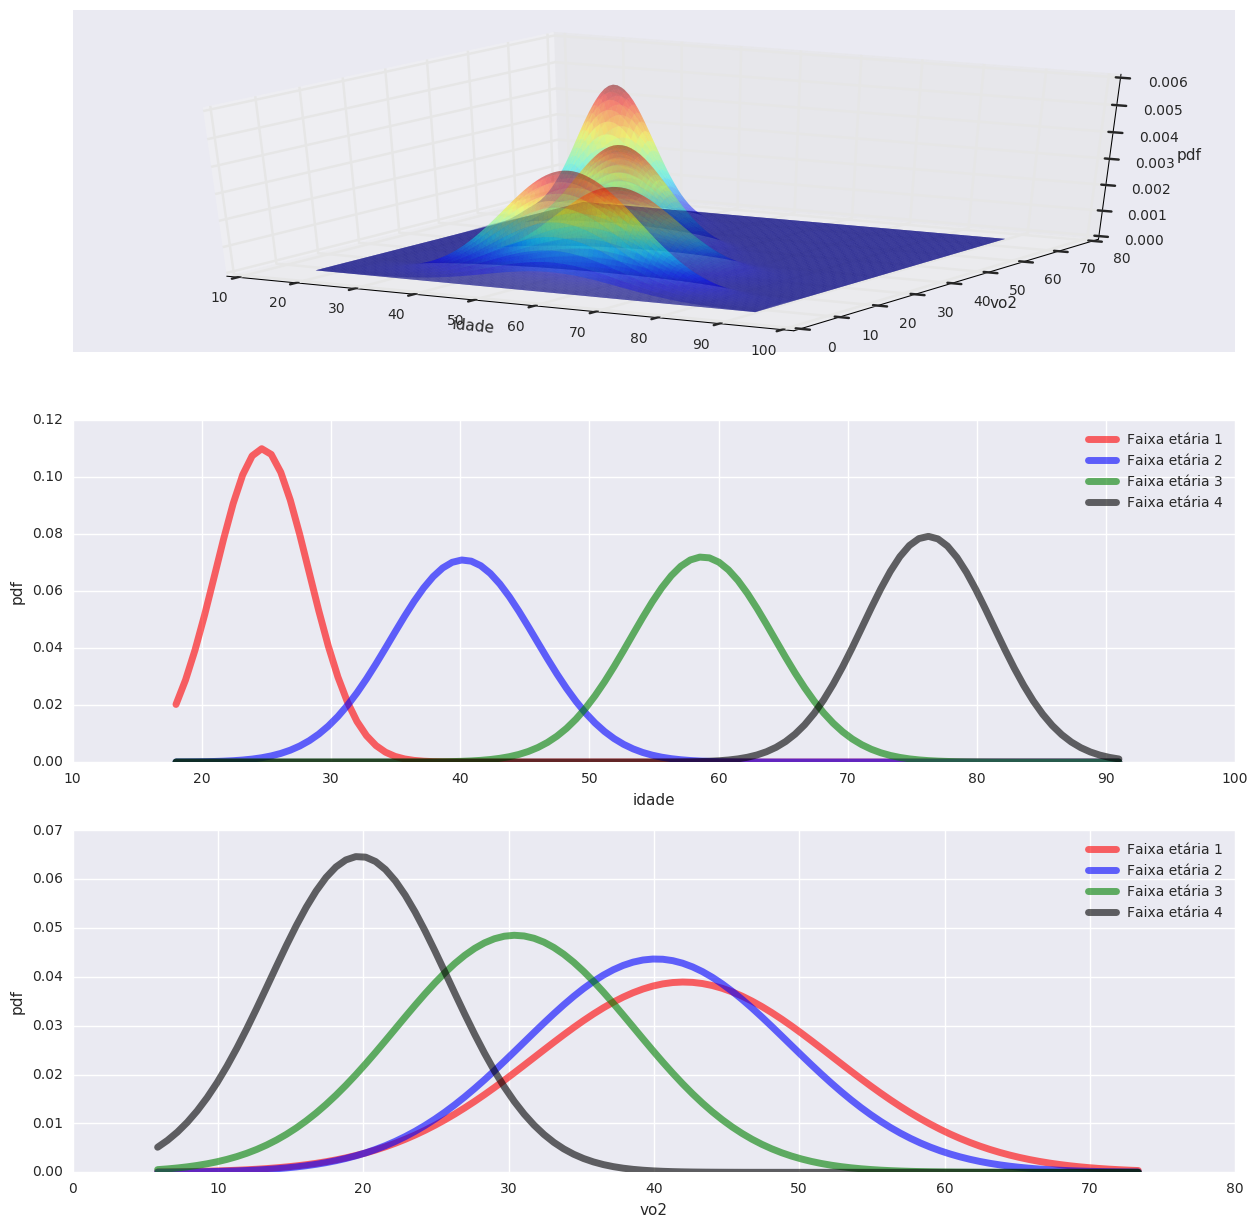

<IPython.core.display.Latex object>

In [306]:
labels = ['idade', 'vo2']
train_data, mu, sigma = get_normais(labels, data['idade'].min(), data['idade'].max(), 
                                    data['vo2'].min(), data['vo2'].max())

output = pypandoc.convert_text(print_result(mu, labels, sigma), 'tex', format='md')
display(Latex(output))

### Parte 4: Com as gaussianas em mãos, para cada dado é possível calcular a pertinência dele a cada gaussiana

A probabilidade final de ocorrência do par (x,y), nesse exemplo, (idade, vo2) é dada pela soma ponderada da pdf para cada gaussiana:

$p(x,y) = \pi_1\mathcal{N}_{1} + \pi_2\mathcal{N}_{2} + \pi_3\mathcal{N}_{3} + \pi_4\mathcal{N}_{4}$

onde $\pi_n = \frac{n_i}{N}$, é a proporção de observações pertencentes àquela gaussiana nos dados de treinamento.

In [307]:
def pi_probabilities(train):
    soma = 0
    pi = np.empty((len(train), 1))
    for i, normal in enumerate(train):
        pi[i] = normal.shape[0]
        soma += normal.shape[0]
    
    pi = pi/soma
    return pi
    
    
def calculate_probabilities(test, mu, sigma, pi):
    test_data = []
    text = ""
    for i, normal in enumerate(test):
        test_normal = normal[labels]
        test_data.append(test_normal)
        for j, element in enumerate(test_normal.sample(1).iterrows()):    
            probabilities = []
            for idx, mu_normal in enumerate(mu):
                probabilities.append(normal_multivariate(mu_normal, sigma[idx], element[1]))
            text += "1. Elemento pertencente originalmente a gaussiana %d: \n %s" %(
                i+1, element[1].to_frame().to_latex())
            text+= "Probabilidades p(x,y) individuais:\n\n" 
            prob_total = 0
            for gaus, item in enumerate(probabilities):
                text += "%d. %d: %.5f\n" %(gaus+1, gaus+1, item)
                prob_total += pi[gaus]*item
            text += "\nProbabilidade p(x,y): %.8f" % prob_total
            text += "\n\n\n"
    return text
        
pi = pi_probabilities(train)
#html = markdown.markdown(calculate_probabilities(test, mu, sigma, pi))
text = calculate_probabilities(test, mu, sigma, pi)
output = pypandoc.convert_text(text, 'tex', format='md', extra_args=['--atx-headers'])
display(Latex(output))

<IPython.core.display.Latex object>

### Refazendo o exemplo, seguindo todos os passos, agora com 2 faixas de idade

#### Parte 2

In [308]:
# Separar o dataset nas respectivas faixas
faixas = []
idade_anterior = 0
for idade in range(45, 100, 45):
    if idade == 90:
        idade = 100
    faixas.append(data[(data['idade'] >= idade_anterior) & (data['idade'] < idade)])
    idade_anterior = idade

idade_total = 0
train = []
test = []
# Separar metade dos dados
for i, item in enumerate(faixas):
    idade = i*45
    idade_total += item.shape[0]
    train.append(item[0:item.shape[0]//2])
    test.append(item[item.shape[0]//2:])
    idade_final = idade+45
    if idade == 0:
        idade = 18
    if idade == 45:
        idade_final = 91
    print("Faixa %d-%d possui %d pessoas para treino e %d para teste." % (idade,idade_final, 
                                                                          train[i].shape[0], test[i].shape[0]))
print("Total de participantes: %d" % idade_total)

Faixa 18-45 possui 173 pessoas para treino e 174 para teste.
Faixa 45-91 possui 412 pessoas para treino e 413 para teste.
Total de participantes: 1172


#### Parte 3

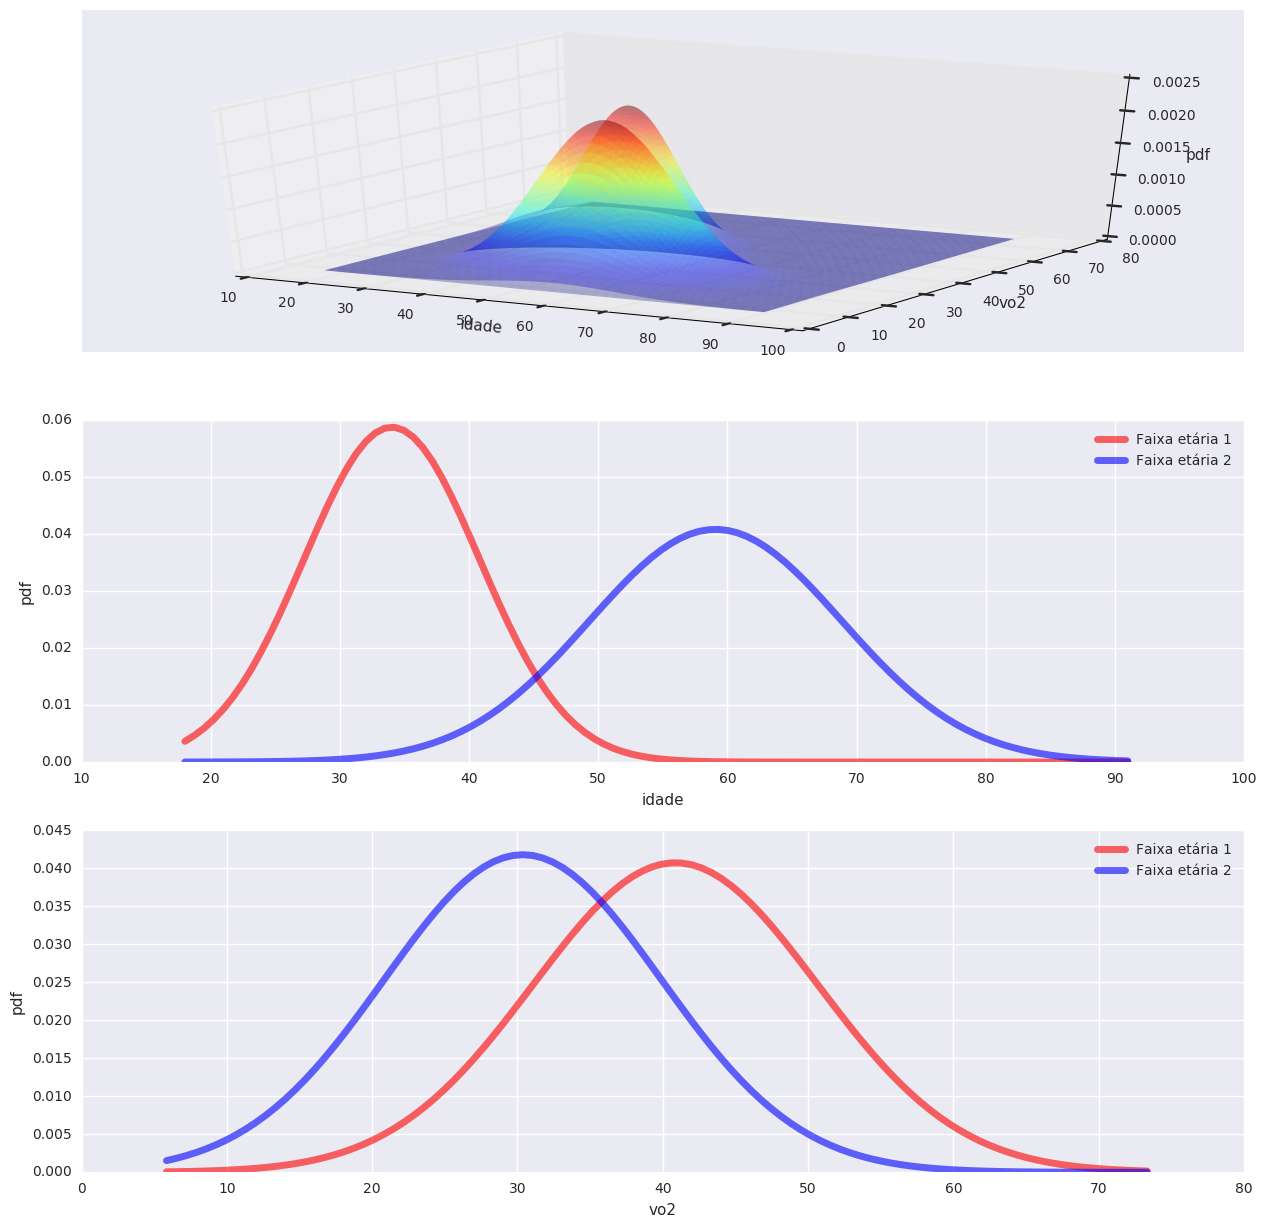

<IPython.core.display.Latex object>

In [309]:
labels = ['idade', 'vo2']
train_data, mu, sigma = get_normais(labels, data['idade'].min(), data['idade'].max(), 
                                    data['vo2'].min(), data['vo2'].max())

output = pypandoc.convert_text(print_result(mu, labels, sigma), 'tex', format='md')
display(Latex(output))

#### Parte 4

In [310]:
pi = pi_probabilities(train)
#html = markdown.markdown(calculate_probabilities(test, mu, sigma, pi))
#display(HTML(html))
text = calculate_probabilities(test, mu, sigma, pi)
output = pypandoc.convert_text(text, 'tex', format='md', extra_args=['--atx-headers'])
display(Latex(output))

<IPython.core.display.Latex object>

#### Comparando os modelos

O modelo da questão 4, o Naive Bayes, assume que cada feature é independente da outra. Além disso, ele é um modelo discriminativo, ou seja, calcula-se a probabilidade do elemento pertencer à classe y dados seus valores ($p(y|x)$). A mistura de Gaussianas, diferentemente, leva em consideração a covariância entre as features, e é um modelo generativo, ou seja, calcula a probabilidade conjunta da ocorrência $p(x,y)$. É possível passar de um resultado a outro utilizando o Teorema de Bayes e então comparar os resultados dos modelos. Mas também é possível escolher nos dois modelos a resposta que retorna a maior probabilidade, seja ela conjunta ou condicional e, se for necessário escolher uma classe só, escolher a classe de maior probabilidade. Uma vantagem da mistura de Gaussianas, é que é possível calcular a pertinência da observação a cada classe, não sendo obrigatório a escolha de uma só.

#### Sorteando 1000 pontos

Para se obter 1000 pontos:
1. Sorteia-se uma das gaussianas a partir de uma distribuição uniforme 
2. Aplica-se a transformação Box-Muller para gerar duas gaussianas de média zero e variância unitária. 
3. Escolhe uma destas gaussianas e a reescala para média e variância correspondentes a gaussiana sorteada no passo 1.
4. Sorteia-se um ponto da gaussiana reescalada no passo 3

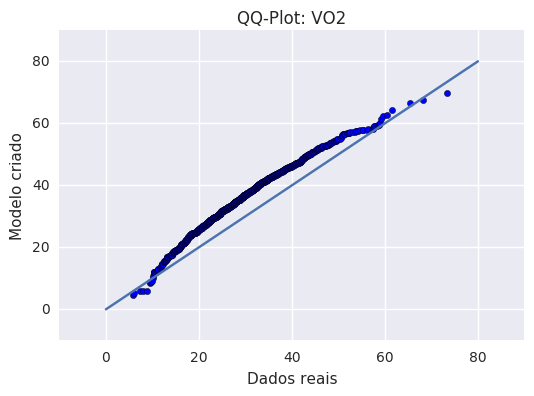

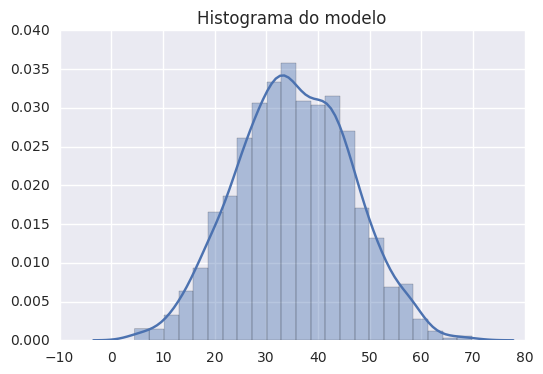

In [327]:
vo2_data = np.empty((data['vo2'].shape[0], 1))

# transformation function
def gaussian(u1,u2):
    z1 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
    z2 = np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)
    return z1,z2

for i, element in enumerate(range(0,data['vo2'].shape[0])):
    gaus = np.random.randint(2)
    
    # uniformly distributed values between 0 and 1
    u1 = np.random.rand(1000)
    u2 = np.random.rand(1000)

    # run the transformation
    z1,z2 = gaussian(u1,u2)
    
    # ajusta variância e média
    z1 = z1*np.sqrt(sigma[gaus][1][1])
    z1 = z1 + mu[gaus]['vo2']
    
    idx = np.random.randint(len(z1))
    vo2_data[i] = z1[idx]

def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)
    plt.plot([0,80],[0,80])
    plt.title("QQ-Plot: VO2")
    plt.xlabel("Dados reais")
    plt.ylabel("Modelo criado")
    plt.show()
    

dd = data['vo2'].copy()
dd.sort_values(inplace=True)
vo2_df = pd.DataFrame(vo2_data, columns=['vo2'])
vo2_df.sort_values('vo2', inplace=True)
qqplot(dd, vo2_df)
ax = sns.distplot(vo2_data)
ax.set_title("Histograma do modelo")
plt.show()